In [1]:
import xgboost as xgb
import awkward as ak
import warnings
import pickle
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

In [3]:
path = '/project01/ndcms/cmoore24/skims/analysis_skims/2017/nolepton/hgg/keep*.parquet'

In [4]:
def add_ratios(ratio, array):
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[4:dash]
    denominator = ratio[dash+1:asterisk]
    exponent = float(ratio[asterisk+2:].replace('_','.'))
    if ratio[:3] == 'grm':
        num_ecf = array.groomed_ecfs[numerator]
        den_ecf = array.groomed_ecfs[denominator]
    elif ratio[:3] == 'ugm':
        num_ecf = array.ungroomed_ecfs[numerator]
        den_ecf = array.ungroomed_ecfs[denominator]
    ecf_ratio = (num_ecf / (den_ecf**exponent))   
    return ecf_ratio

In [5]:
# def nan_remover(sample):
#     if type(sample) == dict:
#         for j in sample:
#             mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
#             mask = ak.fill_none(mask, True)
#             for k in sample[j].fields:
#                 mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
#             sample[j] = sample[j][mask]
#     else:
#         mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
#         mask = ak.fill_none(mask, True)
#         for j in sample.fields:
#             if sample[j].fields == []:
#                 mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
#             else:
#                 for k in sample[j].fields:
#                     mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
#         sample = sample[mask]
#     return mask

In [6]:
ratios = 160

model_path = f'/scratch365/cmoore24/training/hgg/final_draft_dev/QCDgg/outputs/{ratios}'

bst = xgb.Booster()
bst.load_model(f'{model_path}/bdt_model.json')

scaler = f'{model_path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

feature_names = bst.feature_names

In [7]:
file = ak.from_parquet(path)

In [8]:
# file = file[nan_remover(file)]

In [9]:
ecf_ratios = {}

for i in feature_names:
    ecf_ratios[i] = add_ratios(i, file)

ecf_ratios = ak.zip(ecf_ratios, depth_limit=1)

In [10]:
file_np = np.column_stack([ak.to_numpy(ecf_ratios[feature]) for feature in feature_names])
file_np = scaler.transform(file_np)
file_xgb = xgb.DMatrix(file_np, feature_names=feature_names)

In [11]:
a = bst.predict(file_xgb)

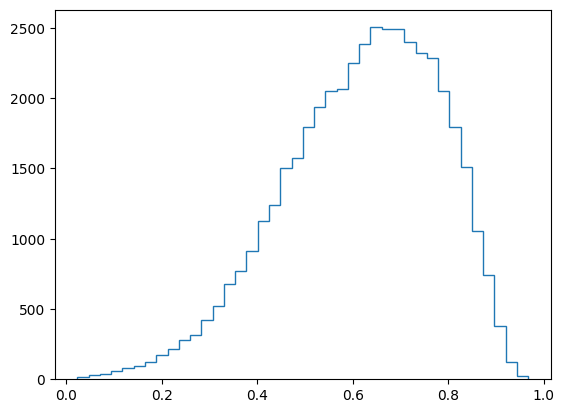

In [14]:
plt.hist(a, bins=40, histtype='step')
plt.show()